# CLASS-HDS Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from classy import Class

In [26]:
# Evoke class, set parameters and solve Einstein-Boltzmann
c = Class()
pars = {
    # Cosmological parameters
    "H0": 67.32,
    "omega_b": 0.022383,
    "omega_cdm": 0.12011,
    "A_s": 2.1e-9,
    "n_s": 0.9649,
    "tau_reio": 0.0544,
    "N_ur": 2,
    "N_ncdm": 1,
    "m_ncdm": 0.06,
    # CLASS settings
    "lensing": "yes",
    "non_linear": "hmcode",
    "output": "mPk,tCl,pCl,lCl",
    "l_max_scalars": 3000,
    "P_k_max_1/Mpc": 10
}
c.set(pars)
c.compute()

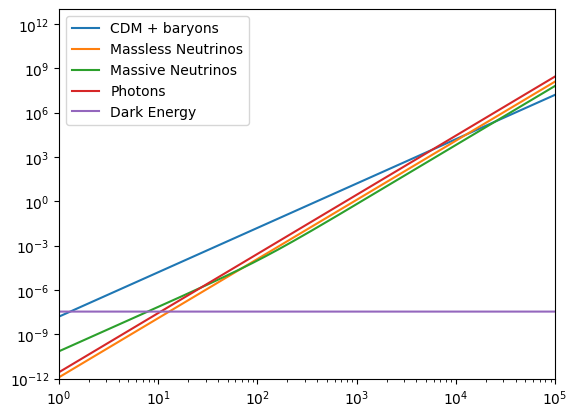

In [36]:
bg = c.get_background()
z = bg["z"]
rho_cb = bg["(.)rho_cdm"] + bg["(.)rho_b"]
rho_nu_massless = bg["(.)rho_ur"]
rho_nu_massive = bg["(.)rho_ncdm[0]"]
rho_phot = bg["(.)rho_g"]
rho_de = bg["(.)rho_lambda"]
rho_tot = bg["(.)rho_tot"]

plt.loglog(1+z, rho_cb, label="CDM + baryons")
plt.loglog(1+z, rho_nu_massless, label="Massless Neutrinos")
plt.loglog(1+z, rho_nu_massive, label="Massive Neutrinos")
plt.loglog(1+z, rho_phot, label="Photons")
plt.loglog(1+z, rho_de, label="Dark Energy")
plt.xlim([1, 1e5])
plt.ylim([1e-12, 1e13])
plt.legend()

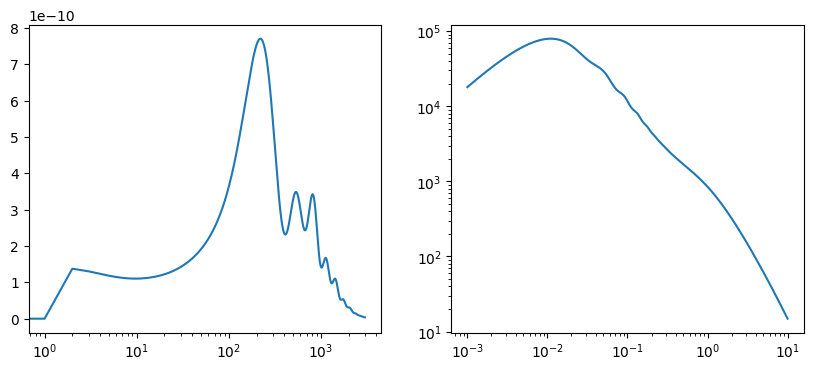

In [27]:
# Extracting P(k) and temperature C_l
k = np.logspace(-3, 1, 200)
z = np.zeros(1)
pk = c.get_pk_array(k, z, len(k), 1, True)
class_cls = c.lensed_cl()
ells = class_cls['ell']
cls = ells*(ells+1)*class_cls['tt']/(2*np.pi)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].semilogx(ells, cls)
axs[1].loglog(k, pk)